Logistic Regression Accuracy: 0.6875909752547307, Cross-Validation Accuracy: 0.6790842999704283
Linear SVM Accuracy: 0.6686681222707423, Cross-Validation Accuracy: 0.6607073894165991


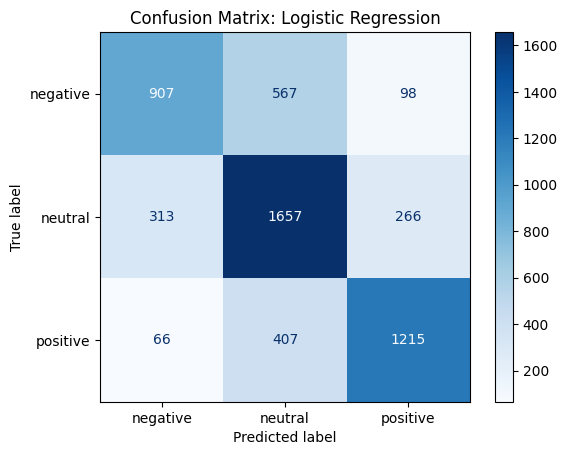

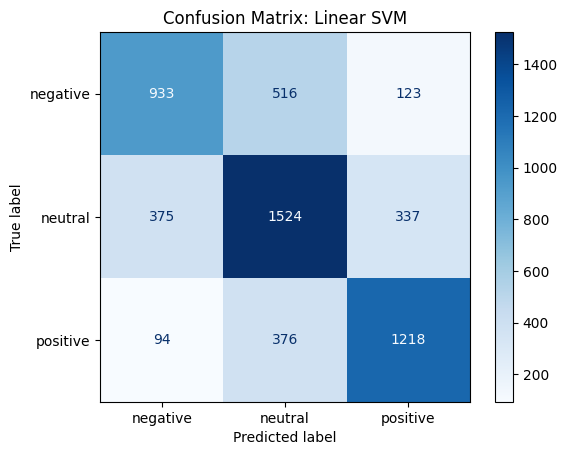

Epoch 1/20, Train Loss: 585.6653, Val Loss: 130.3324, Val Accuracy: 0.6725
Best model saved.
Epoch 2/20, Train Loss: 460.2829, Val Loss: 130.4399, Val Accuracy: 0.6729
Best model saved.
Epoch 3/20, Train Loss: 381.6811, Val Loss: 135.5928, Val Accuracy: 0.6701
Epoch 4/20, Train Loss: 273.9925, Val Loss: 147.1076, Val Accuracy: 0.6612
Epoch 5/20, Train Loss: 237.8013, Val Loss: 155.5858, Val Accuracy: 0.6668
Epoch 6/20, Train Loss: 212.8944, Val Loss: 163.2319, Val Accuracy: 0.6634
Epoch 7/20, Train Loss: 186.2182, Val Loss: 161.0230, Val Accuracy: 0.6630
Early stopping triggered.


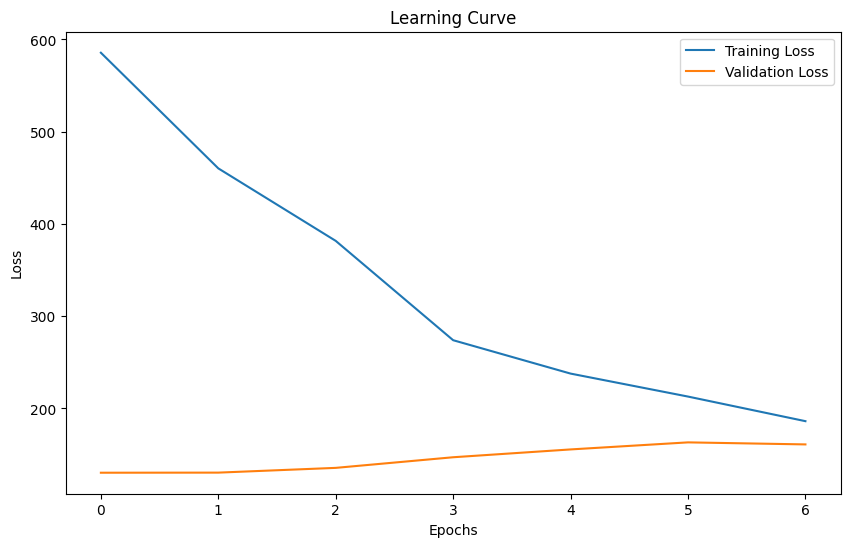

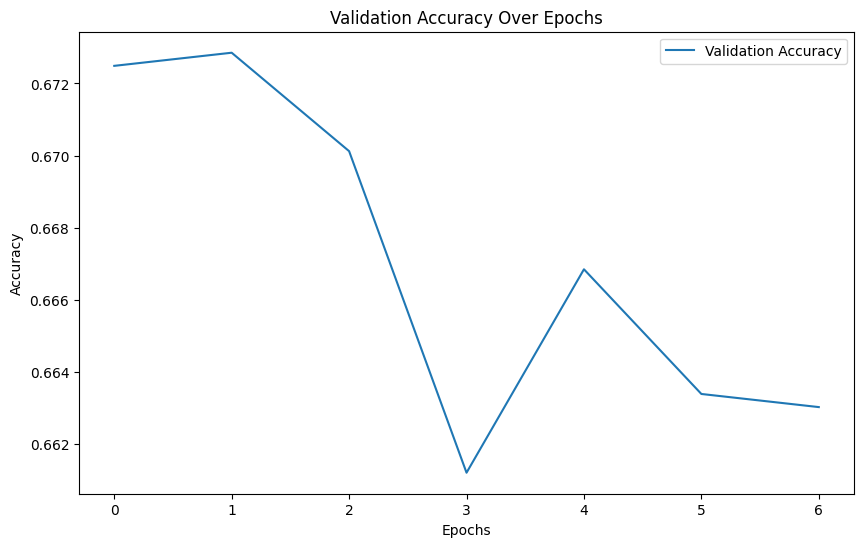

Training complete. Best PyTorch model saved as './best_pytorch_model.pth'

Standalone Inference Example
Predicted Sentiment: ['positive']


C:\Users\Noah\AppData\Local\Temp\ipykernel_15216\1340189222.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./best_pytorch_model.pth'

In [21]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import plotly.express as px
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pickle

# Load datasets
train_file_path = './data/train.csv'
test_file_path = './data/test.csv'
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Drop missing values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['sentiment'])

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], y, test_size=0.2, random_state=42)

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_val_tfidf = tfidf_vectorizer.transform(X_val).toarray()

# Save vectorizer and label encoder for inference
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Classical models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Linear SVM": LinearSVC(max_iter=1000),
    # "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

model_results = {}

for model_name, model in models.items():
    scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    model.fit(X_train_tfidf, y_train)
    y_val_pred = model.predict(X_val_tfidf)
    accuracy = accuracy_score(y_val, y_val_pred)
    model_results[model_name] = {
        "accuracy": accuracy,
        "classification_report": classification_report(y_val, y_val_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_val, y_val_pred),
        "cross_val_accuracy": scores.mean()
    }
    print(f"{model_name} Accuracy: {accuracy}, Cross-Validation Accuracy: {scores.mean()}")

# Visualizing learning curve and confusion matrix
for model_name, results in model_results.items():
    ConfusionMatrixDisplay(confusion_matrix=results["confusion_matrix"], display_labels=label_encoder.classes_).plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

# Deep learning with PyTorch
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SentimentDataset(X_train_tfidf, y_train)
val_dataset = SentimentDataset(X_val_tfidf, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

class SentimentModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SentimentModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Increase dropout rate for regularization
        self.fc2 = nn.Linear(512, 256)
        self.batch_norm = nn.BatchNorm1d(256)  # Add BatchNorm for stability
        self.fc3 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model
input_dim = X_train_tfidf.shape[1]
output_dim = len(label_encoder.classes_)
model = SentimentModel(input_dim, output_dim)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)  # Use AdamW for better optimization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Learning rate scheduler

# Training loop with early stopping
def train_model(model, train_loader, val_loader, epochs, patience):
    best_val_accuracy = 0
    patience_counter = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        val_accuracy = correct / total
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), './best_pytorch_model.pth')
            print("Best model saved.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step()

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
    plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
    plt.title("Learning Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy")
    plt.title("Validation Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

train_model(model, train_loader, val_loader, epochs=20, patience=5)

# Final message
print("Training complete. Best PyTorch model saved as './best_pytorch_model.pth'")

# Standalone inference example
print("\nStandalone Inference Example")
import pickle
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

def load_model_and_infer(text):
    # Load pre-saved artifacts
    with open('tfidf_vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)
    with open('label_encoder.pkl', 'rb') as f:
        encoder = pickle.load(f)
    model = SentimentModel(input_dim=5000, output_dim=len(encoder.classes_))
    model.load_state_dict(torch.load('./best_pytorch_model.pth'))
    model.eval()

    # Preprocess and vectorize input
    text = preprocess_text(text)
    vectorized = vectorizer.transform([text]).toarray()
    tensor_input = torch.tensor(vectorized, dtype=torch.float32)

    # Predict
    with torch.no_grad():
        outputs = model(tensor_input)
        _, predicted = torch.max(outputs, 1)
    return encoder.inverse_transform(predicted.numpy())

example_text = "This is a great product!"
print("Predicted Sentiment:", load_model_and_infer(example_text))


<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


C:\Users\Noah\AppData\Local\Temp\ipykernel_15216\1798575546.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='sentiment', order=sentiment_distribution.index, palette='viridis')


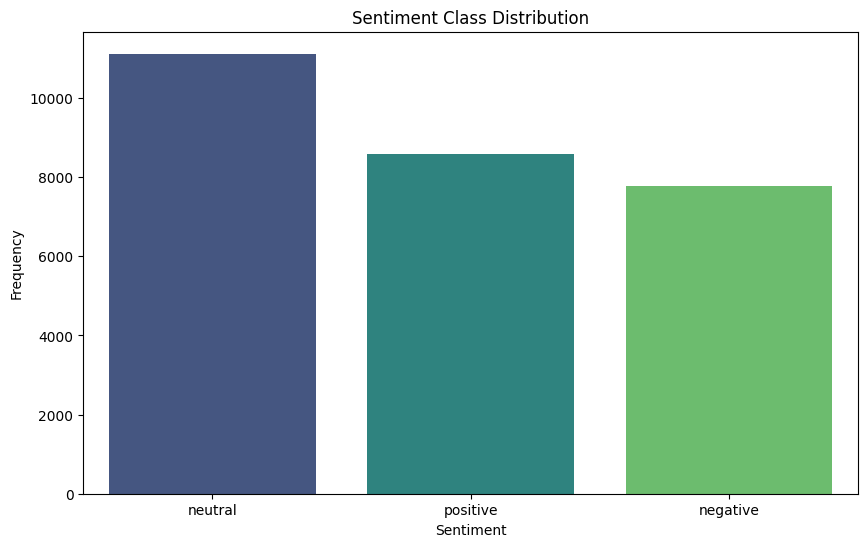

C:\Users\Noah\AppData\Local\Temp\ipykernel_15216\1798575546.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='sentiment', y='text_length', palette='viridis')


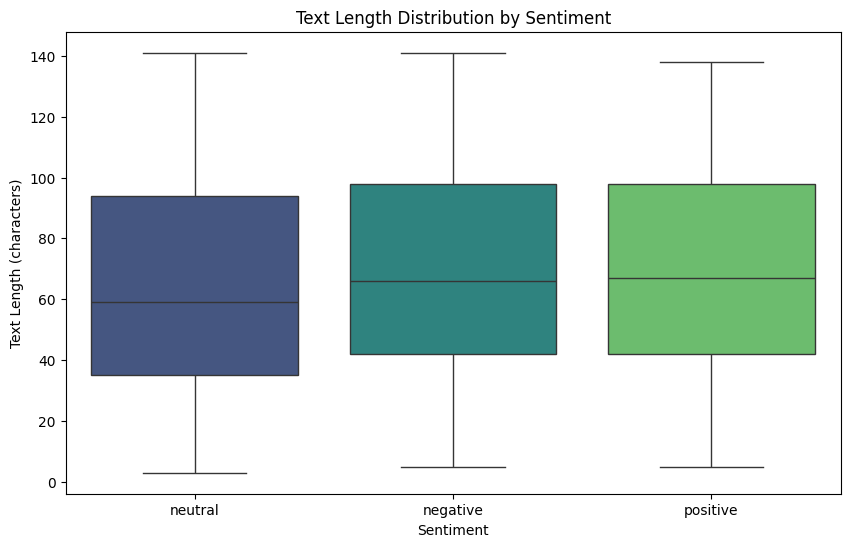

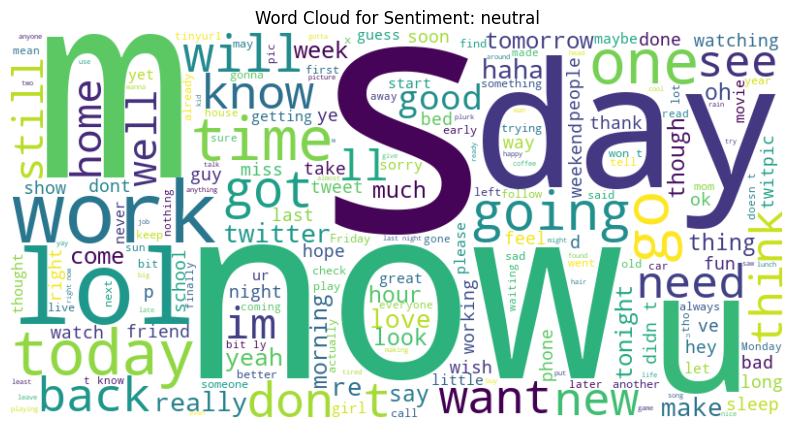

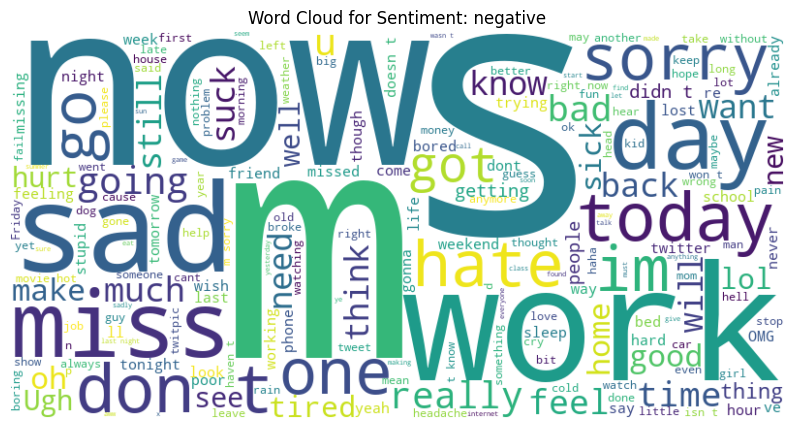

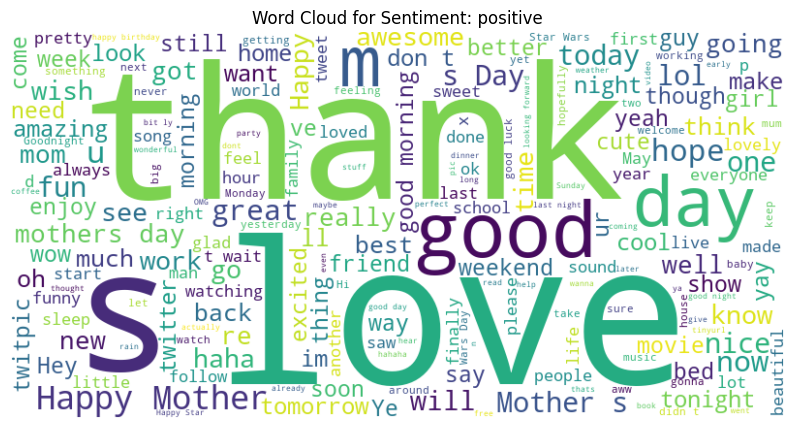

{'Train Shape': (27480, 4),
 'Test Shape': (3534, 3),
 'Sentiment Distribution (%)': sentiment
 neutral     40.454876
 positive    31.229985
 negative    28.315138
 Name: proportion, dtype: float64,
 'Text Length Stats':              count       mean        std  min   25%   50%   75%    max
 sentiment                                                             
 negative    7781.0  70.488112  35.155991  5.0  42.0  66.0  98.0  141.0
 neutral    11117.0  65.206800  36.407550  3.0  35.0  59.0  94.0  141.0
 positive    8582.0  70.419133  34.647770  5.0  42.0  67.0  98.0  138.0,
 'Word Count Stats':              count       mean       std  min  25%   50%   75%   max
 sentiment                                                          
 negative    7781.0  13.473204  6.874375  1.0  8.0  13.0  19.0  32.0
 neutral    11117.0  12.343888  7.056730  1.0  6.0  11.0  18.0  33.0
 positive    8582.0  13.109881  6.746352  1.0  8.0  12.0  18.0  33.0}

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import numpy as np

# File paths from uploaded files
train_file_path = './data/train.csv'
test_file_path = './data/test.csv'

# Load the train and test datasets
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Drop missing values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Basic information about the datasets
train_shape = train_df.shape
test_shape = test_df.shape
train_info = train_df.info()

# Distribution of sentiment classes
sentiment_distribution = train_df['sentiment'].value_counts(normalize=True) * 100

# Analyze text lengths (number of characters and words)
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

# Aggregate statistics for text length and word count by sentiment
text_length_stats = train_df.groupby('sentiment')['text_length'].describe()
word_count_stats = train_df.groupby('sentiment')['word_count'].describe()

# Generate word clouds for each sentiment
def generate_wordcloud(data, sentiment):
    text = " ".join(data[data['sentiment'] == sentiment]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    return wordcloud

wordclouds = {sent: generate_wordcloud(train_df, sent) for sent in train_df['sentiment'].unique()}

# Prepare summary statistics for display
summary_stats = {
    "Train Shape": train_shape,
    "Test Shape": test_shape,
    "Sentiment Distribution (%)": sentiment_distribution,
    "Text Length Stats": text_length_stats,
    "Word Count Stats": word_count_stats
}

# Visualize data insights
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='sentiment', order=sentiment_distribution.index, palette='viridis')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()

# Visualizing text lengths
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='sentiment', y='text_length', palette='viridis')
plt.title("Text Length Distribution by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Text Length (characters)")
plt.show()

# Displaying word clouds
for sentiment, wc in wordclouds.items():
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Word Cloud for Sentiment: {sentiment}")
    plt.axis('off')
    plt.show()

summary_stats
